In [1]:
import btrdb
import numpy as np
import pandas as pd
import time

from tabulate import tabulate
from btrdb.utils.timez import ns_delta
from btrdb.utils.timez import ns_delta, to_nanoseconds
from btrdb.utils.timez import ns_to_datetime
from btrdb.utils.general import pointwidth

# Plotting
import matplotlib.pyplot as plt
#plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Insert your API key here!
APIKEY='YOUR API KEY HERE'

db = btrdb.connect("api.ni4ai.org:4411", apikey=APIKEY)
db.info()

{'majorVersion': 5, 'build': '5.11.37', 'proxy': {'proxyEndpoints': []}}

In [3]:
# Get voltage streams
uuids = db.query("SELECT collection, name FROM streams WHERE collection like 'sunshine/%' and unit='volts'")
names = [row["collection"]+"/"+row["name"] for row in uuids]

streams = db.streams(*names)

In [4]:
# Print table of streams
table = [["UUID", "Collection", "Name", "Unit"]]
for stream in streams:
    table.append([stream.uuid, stream.collection, stream.tags()["name"], stream.tags()["unit"]])
print(tabulate(table, headers="firstrow", tablefmt="simple"))

UUID                                  Collection     Name    Unit
------------------------------------  -------------  ------  ------
d60fc469-a6da-4c98-8763-fd833293d955  sunshine/PMU6  L2MAG   volts
4833b5e0-ef30-40ed-8db8-352e79d38c28  sunshine/PMU6  L3MAG   volts
6ef43c96-9429-48db-9d37-bffd981b4a24  sunshine/PMU2  L2MAG   volts
d3e9ed52-6db9-4b98-bfda-e1b509148e47  sunshine/PMU6  L1MAG   volts
e290a69d-1e52-4411-bccd-da7c3f39531c  sunshine/PMU2  L1MAG   volts
b4920286-9aaa-4ca0-82ac-937e3ff7d8e8  sunshine/PMU2  L3MAG   volts
0295f80f-6776-4384-b563-4582f7256600  sunshine/PMU3  L1MAG   volts
38d62795-6341-4069-96d3-fe74bffcac67  sunshine/PMU3  L2MAG   volts
37539589-88aa-48b7-8cb4-1ea2f32c9e8d  sunshine/PMU3  L3MAG   volts
08060a62-04c0-4597-8d2f-7df58e461ba2  sunshine/PMU4  L1MAG   volts
5031918c-346f-4488-9755-b3917153e607  sunshine/PMU4  L3MAG   volts
08aac678-a2f5-4a9c-9c18-c569cd414368  sunshine/PMU4  L2MAG   volts
b2936212-253e-488a-87f6-a9927042031f  sunshine/PMU1  L3MAG   v

## What are voltage sags?
A brief dip in voltage level is classified as a voltage sag when it exceeds 0.9 pu and lasts from 0.5 cycles to 0.5 seconds. Voltage sags smaller than this amount would generally go unnoticed or be neglected, but the power of BTrDB allows us to study even smaller dips. In the following, we find voltage sags across several days of measurements from the sunshine dataset. 

### Finding voltage sags
To find the voltage sags, we first write a depth-first-search function to find the timestamps below our voltage sag threshold. 

In [5]:
from btrdb.utils.general import pointwidth
from btrdb.utils.timez import ns_to_datetime

def find_vsags_dfs(
    stream,
    tau,
    start=btrdb.MINIMUM_TIME,
    end=btrdb.MAXIMUM_TIME,
    pw=48,
    version=0
):
    # Ensure pw is a pointwidth object
    pw = pointwidth(pw)

    # Begin by collecting all stat points at the specified pointwidth
    # Note that zip creates a list of windows and versions and we ignore the versions
    windows, _ = zip(*stream.aligned_windows(start, end, pw, version))

    # Traversing from left to right from the windows
    for window in windows:
        # Check to see if the value is in the window
        if window.min <= tau:
            # Get the time range of the current window
            wstart = window.time
            wend = window.time + pw.nanoseconds

            if pw <= 30:
                # If we are at a window length of a second, use values
                points, _ = zip(*stream.values(wstart, wend, version))
            else:
                # Otherwise, traverse the stat point children of this node
                points = find_vsags_dfs(stream, tau, wstart, wend, pw-1, version)

            # Yield all points to the calling function
            for point in points:
                if point.value <= tau:
                    yield point

                    
###########################################################################
# Utility functions

# Converts pointwidths to seconds
def seconds2pointwidth(seconds):
    return np.log(1e9*seconds) / np.log(2); 

# Returns the mean value of a stream. Useful for automatically getting the 
# nominal voltage
def get_mean_value(stream, version=0):
    # Get all of the stat points at the highest level of the tree as possible
    windows = stream.aligned_windows(
        start=btrdb.MINIMUM_TIME, end=btrdb.MAXIMUM_TIME, pointwidth=60, version=version
    )

    # Unless you have decades of data, this will likely only be one stat point
    values = [window.mean for window, _ in windows]
    return np.mean(values)

# Gets window of data around point
def get_event(stream, time, window = 0.5, version=0):
    window = 1e9 * window; 
    points, _ = zip(*stream.values(time-window, time+window, version)); 
    T = len(points); 
    values = np.zeros(T);
    
    for i in range(T):
        values[i] = points[i][1]
    
    return values

def freq_vs_size(size_min, size_max):
    x = np.arange(size_min, size_max, 0.001); 
    y = x / (1-x); 
    area = integral(size_max) - integral(size_min);
    return x, y / area; 
    
def integral(x):
    return -x-np.log(1-x);

In [6]:
start = "2015-10-31T00:00:00.000Z"
end = "2015-11-05T00:00:00.000Z"
# Sunshine PMU 1
stream = streams["35bdb8dc-bf18-4523-85ca-8ebe384bd9b5"];
vnom = get_mean_value(stream); 
thresh = 0.9 * vnom; 

sags = find_vsags_dfs(stream, thresh, start=start, end=end); 

Visualize a voltage sags from PMU 1 of the sunshine dataset. 

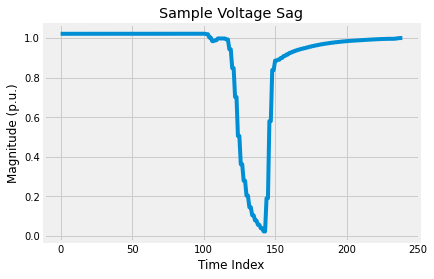

In [7]:
sag_point = next(sags);
sag_data = get_event(stream, sag_point[0]);
plt.figure(); plt.plot(sag_data / vnom); plt.title('Sample Voltage Sag');
plt.xlabel('Time Index'); plt.ylabel('Magnitude (p.u.)');


#plt.tight_layout();
#plt.savefig('example_sag', dpi=100);

Now that we have a function that finds voltage sags, we can write functions to analyze aspects of the sags, such as their size and duration. 

In [8]:
def sag_survey(sags, verbose=False, limit=100):
    # Initialize sag information
    starts = [];
    durations = [];
    magnitudes = []; 
    
    # Get the first sag
    sag = safe_next(sags);
    if sag==None: 
        print("No voltage sags found.")
    else:
        if verbose: print("Voltage sag found!")
        start, mag = sag;
        dur = 0; 
    
    count = 0; 
    while sag:
        sag = safe_next(sags);
        
        # If we are on the last sag
        if (sag == None) or (count > limit):
            starts.append(start);
            durations.append(dur);
            magnitudes.append(mag);
            sag = None; 
        else:
            sag_time, sag_value = sag;
            # Check if this is a different sag
            # More than 1 s after last sag point
            if sag_time - (start + dur) > 1e9:
                if verbose: print("Voltage sag found!", count)
                # Save last sag
                starts.append(start);
                durations.append(dur);
                magnitudes.append(mag);
                # Increment sag count
                count += 1; 
                # Initialize next sag
                start = sag_time; 
                mag = sag_value;
                dur = 0; 
            # Otherwise update properties of this sag
            else:
                dur = sag_time - start; 
                mag = min(mag, sag_value)
                
    return np.array(starts), np.array(durations), np.array(magnitudes)

# A convenience for iterating through a generator
def safe_next(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first

### Find voltage sags over one month of data
We look at voltage sags from November 20, 2016 to December 20, 2016. 

In [9]:
# Choose the stream
# PMU 1 from sunshine dataset
stream = streams["35bdb8dc-bf18-4523-85ca-8ebe384bd9b5"];
# Get nominal voltage of stream
vnom = get_mean_value(stream); 

# Start and end times of period to study
start = "2016-11-20T00:00:00.000Z"
end = "2016-12-20T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
thresh = 0.98 * vnom; 

# For timing - start
go = time.time(); 

# Find voltage sag data points
sags = find_vsags_dfs(stream, thresh, start=start, end=end); 
# Get features of voltage sags
starts, durs, mags = sag_survey(sags, verbose=False);

# For timing - end
stop = time.time(); 

# Print magnitudes of sags
print(mags)
print('Time: ', stop-go)

[6769.92675781 6753.34423828 6851.39550781 6591.23486328]
Time:  6.672967195510864


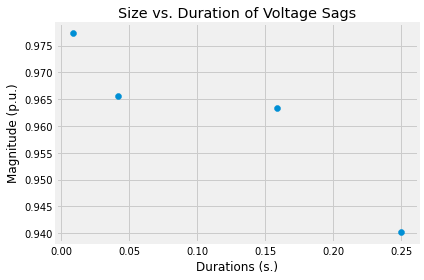

In [10]:
plt.scatter(durs / 1e9, mags / vnom);
plt.title('Size vs. Duration of Voltage Sags');
plt.xlabel('Durations (s.)'); plt.ylabel('Magnitude (p.u.)');

plt.tight_layout();
plt.savefig('size_vs_durs', dpi=100);

### Find voltage sags over 3 months of data.
We look at voltage sags from November 19, 2016 to February 4, 2017. 

In [11]:
# Choose the stream
# PMU 1 from sunshine dataset
stream = streams["35bdb8dc-bf18-4523-85ca-8ebe384bd9b5"];
# Get nominal voltage of stream
vnom = get_mean_value(stream); 

# Start and end times of period to study
start = "2016-11-19T00:00:00.000Z"
end = "2017-02-04T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
thresh = 0.99 * vnom; 

# Find voltage sag data points
sags = find_vsags_dfs(stream, thresh, start=start, end=end); 
# Get features of voltage sags
starts, durs, mags = sag_survey(sags, verbose=False);

### Sag Features
Now we can explore patterns and features of the voltage sags found across several months of data. 

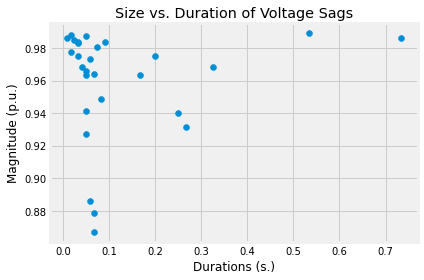

In [12]:
plt.scatter(durs / 1e9, mags / vnom);
plt.title('Size vs. Duration of Voltage Sags');
plt.xlabel('Durations (s.)'); plt.ylabel('Magnitude (p.u.)');

plt.tight_layout();
plt.savefig('size_vs_durs', dpi=100);

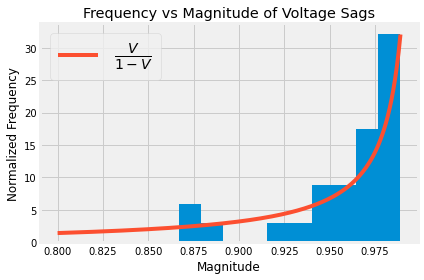

In [13]:
# Plot a histogram of the normalized magnitude
# of the voltage sags
pmags = mags / vnom; 
plt.hist(pmags, density=True);

# A result in the literature says that the frequency of
# a voltage sag with minimum value V will be V / (1-V)
# Plot this fit
x, y = freq_vs_size(0.8, 0.99);
plt.plot(x, y, label = r'$\frac{V}{1-V}$');

# Add keys
plt.legend(fontsize=20); 
plt.title('Frequency vs Magnitude of Voltage Sags'); 
plt.xlabel('Magnitude'); plt.ylabel('Normalized Frequency');

plt.tight_layout();
plt.savefig('freq_vs_voltage', dpi=100);

### Compare voltage sag occurrences at multiple locations. 

In [14]:
# Choose the stream
# PMU 1 from sunshine dataset (PV site)
stream1 = streams["35bdb8dc-bf18-4523-85ca-8ebe384bd9b5"];
# PMU 3 from sunshine dataset (substation above PV site)
stream2 = streams["0295f80f-6776-4384-b563-4582f7256600"]
# PMU 4 from sunshine dataset (substation)
stream3 = streams["08060a62-04c0-4597-8d2f-7df58e461ba2"];
# PMU 5 from sunshine dataset (substation)
stream4 = streams["edb36769-f56f-47c5-bbda-a177c424cc4f"];

# Get nominal voltage of stream
vnom1 = get_mean_value(stream1); 
vnom2 = get_mean_value(stream2);
vnom3 = get_mean_value(stream3);
vnom4 = get_mean_value(stream4);

# Start and end times of period to study
start = "2016-03-01T00:00:00.000Z"
end = "2016-06-01T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
level = 0.97
thresh1 = level * vnom1; 
thresh2 = level * vnom2; 
thresh3 = level * vnom3; 
thresh4 = level * vnom4;

# Find voltage sag data points
sags1 = find_vsags_dfs(stream1, thresh1, start=start, end=end);
sags2 = find_vsags_dfs(stream2, thresh2, start=start, end=end); 
sags3 = find_vsags_dfs(stream3, thresh3, start=start, end=end);
sags4 = find_vsags_dfs(stream4, thresh4, start=start, end=end);

# Get features of voltage sags
print("Searching in stream 1...")
starts1, durations1, magnitudes1 = sag_survey(sags1, verbose=True);
print("Searching in stream 2...")
starts2, durations2, magnitudes2 = sag_survey(sags2, verbose=True);
print("Searching in stream 3...")
starts3, durations3, magnitudes3 = sag_survey(sags3, verbose=True);
print("Searching in stream 4...")
starts4, durations4, magnitudes4 = sag_survey(sags4, verbose=True);

Searching in stream 1...
Voltage sag found!
Voltage sag found! 0
Voltage sag found! 1
Voltage sag found! 2
Voltage sag found! 3
Voltage sag found! 4
Voltage sag found! 5
Voltage sag found! 6
Voltage sag found! 7
Voltage sag found! 8
Voltage sag found! 9
Searching in stream 2...
Voltage sag found!
Voltage sag found! 0
Voltage sag found! 1
Voltage sag found! 2
Voltage sag found! 3
Voltage sag found! 4
Voltage sag found! 5
Voltage sag found! 6
Voltage sag found! 7
Voltage sag found! 8
Voltage sag found! 9
Voltage sag found! 10
Voltage sag found! 11
Voltage sag found! 12
Voltage sag found! 13
Voltage sag found! 14
Voltage sag found! 15
Voltage sag found! 16
Voltage sag found! 17
Voltage sag found! 18
Voltage sag found! 19
Voltage sag found! 20
Voltage sag found! 21
Voltage sag found! 22
Voltage sag found! 23
Voltage sag found! 24
Voltage sag found! 25
Voltage sag found! 26
Searching in stream 3...
Voltage sag found!
Voltage sag found! 0
Voltage sag found! 1
Voltage sag found! 2
Voltage sag

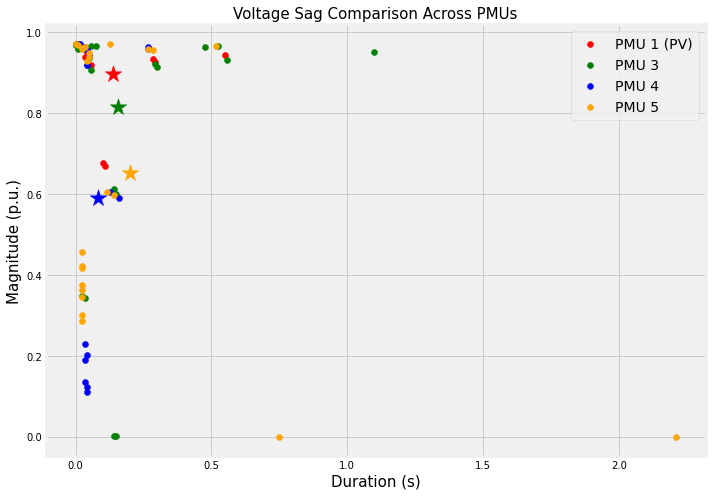

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(durations1 / 1e9, magnitudes1 / vnom1, c='r', label='PMU 1 (PV)');
plt.scatter(durations2 / 1e9, magnitudes2 / vnom2, c='g', label='PMU 3');
plt.scatter(durations3 / 1e9, magnitudes3 / vnom3, c='b', label='PMU 4');
plt.scatter(durations4 / 1e9, magnitudes4 / vnom4, c='orange', label='PMU 5');
plt.legend(fontsize=14); 

# Plot average durations and magnitude for each PMU
plt.scatter(np.mean(durations1 / 1e9), np.mean(magnitudes1 / vnom1), c='r', s=300, marker='*');
plt.scatter(np.mean(durations2 / 1e9), np.mean(magnitudes2 / vnom2), c='g', s=300, marker='*');
plt.scatter(np.mean(durations3 / 1e9), np.mean(magnitudes3 / vnom3), c='b', s=300, marker='*');
plt.scatter(np.mean(durations4 / 1e9), np.mean(magnitudes4 / vnom4), c='orange', s=300, marker='*');

plt.xlabel("Duration (s)", fontsize=15); 
plt.ylabel("Magnitude (p.u.)", fontsize=15);
plt.title("Voltage Sag Comparison Across PMUs", fontsize=15);

plt.tight_layout();
plt.savefig('sag_comparison', dpi=100);

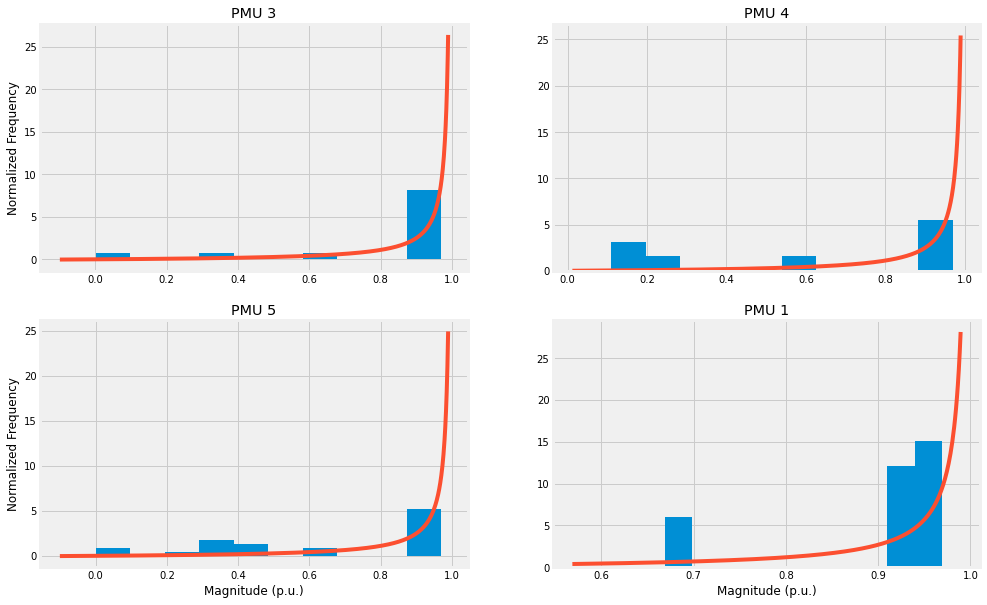

In [16]:
# Histogram comparing size of sags. 
fig = plt.figure(figsize=(15, 10)); 

plt.subplot(2, 2, 1)
plt.hist(magnitudes2 / vnom2, density=True);
min_mag = np.min(magnitudes2 / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 3')
plt.ylabel('Normalized Frequency')

plt.subplot(2, 2, 2)
plt.hist(magnitudes3 / vnom3, density=True);
min_mag = np.min(magnitudes3 / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 4')

plt.subplot(2, 2, 3)
plt.hist(magnitudes4 / vnom4, density=True);
min_mag = np.min(magnitudes4 / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 5')
plt.xlabel('Magnitude (p.u.)')
plt.ylabel('Normalized Frequency')

plt.subplot(2, 2, 4)
plt.hist(magnitudes1 / vnom1, density=True);
min_mag = np.min(magnitudes1 / vnom ) - 0.1; 
x, y = freq_vs_size(min_mag, 0.99);
plt.plot(x, y)
plt.title('PMU 1')
plt.xlabel('Magnitude (p.u.)');

### Weekly patterns in voltage sags. 

In [17]:
# PMU 4 from sunshine dataset (substation)
stream1 = streams["08060a62-04c0-4597-8d2f-7df58e461ba2"];
# PMU 5 from sunshine dataset (substation)
stream2 = streams["edb36769-f56f-47c5-bbda-a177c424cc4f"];

# Get nominal voltage of stream
vnom1 = get_mean_value(stream1); 
vnom2 = get_mean_value(stream2);

# Start and end times of period to study
start = "2016-03-01T00:00:00.000Z"
end = "2016-06-01T00:00:00.000Z"

# Threshold below which data is considered a voltage sag
level = 0.98
thresh1 = level * vnom1; 
thresh2 = level * vnom2; 

# Find voltage sag data points
sags1 = find_vsags_dfs(stream1, thresh1, start=start, end=end);
sags2 = find_vsags_dfs(stream2, thresh2, start=start, end=end); 

# Get features of voltage sags
print("Searching in stream 1...")
starts1, durations1, magnitudes1 = sag_survey(sags1, verbose=True);
print("Searching in stream 2...")
starts2, durations2, magnitudes2 = sag_survey(sags2, verbose=True);

Searching in stream 1...
Voltage sag found!
Voltage sag found! 0
Voltage sag found! 1
Voltage sag found! 2
Voltage sag found! 3
Voltage sag found! 4
Voltage sag found! 5
Voltage sag found! 6
Voltage sag found! 7
Voltage sag found! 8
Voltage sag found! 9
Voltage sag found! 10
Voltage sag found! 11
Voltage sag found! 12
Voltage sag found! 13
Voltage sag found! 14
Voltage sag found! 15
Voltage sag found! 16
Voltage sag found! 17
Voltage sag found! 18
Voltage sag found! 19
Voltage sag found! 20
Voltage sag found! 21
Voltage sag found! 22
Voltage sag found! 23
Voltage sag found! 24
Voltage sag found! 25
Voltage sag found! 26
Voltage sag found! 27
Voltage sag found! 28
Voltage sag found! 29
Voltage sag found! 30
Voltage sag found! 31
Voltage sag found! 32
Voltage sag found! 33
Voltage sag found! 34
Voltage sag found! 35
Voltage sag found! 36
Voltage sag found! 37
Voltage sag found! 38
Voltage sag found! 39
Voltage sag found! 40
Voltage sag found! 41
Voltage sag found! 42
Voltage sag found! 4

In [18]:
def get_day_counts(times):
    counts = np.zeros(7)
    
    N = np.size(times);
    days = np.zeros(N);
    
    i = 0; 
    for time in times:
        dt = ns_to_datetime(time);
        day = int(dt.weekday());
        counts[day] += 1;
        days[i] = day; i = i + 1;
    return counts, days;

counts1, D1 = get_day_counts(starts1);
counts2, D2 = get_day_counts(starts2);

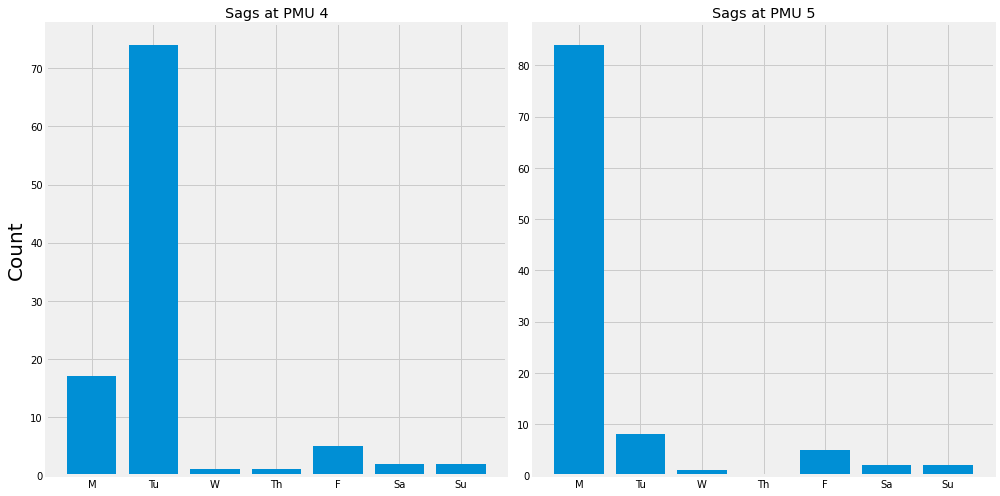

In [19]:
daysofweek = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

    
plt.figure(figsize=(14, 7)); 
plt.subplot(1, 2, 1)
plt.bar(daysofweek, counts1, align='center');
plt.title('Sags at PMU 4'); 
plt.ylabel('Count', fontsize=20)

plt.subplot(1, 2, 2)
plt.bar(daysofweek, counts2, align='center');
plt.title('Sags at PMU 5');

plt.tight_layout();
plt.savefig('sags_by_day', dpi=100);